In [41]:
import torch
import torch.nn as nn
import numpy as np

In [42]:
def conv1d(vector, kernel):
    # Length of the input vector
    input_length = len(vector)
    # Length of the kernel
    kernel_length = len(kernel)
    # Padding size
    padding = kernel_length // 2
    # Pad the input vector
    padded_vector = np.pad(vector, (padding, padding), mode='constant')
    # Convolution result
    result = np.zeros(input_length)
    # Perform convolution
    for i in range(input_length):
        result[i] = np.sum(padded_vector[i:i+kernel_length] * kernel)
    return result

In [43]:
def conv1d_withoutpadding(input_signal, kernel):
    # Low pass filter
    input_len = len(input_signal)
    kernel_len = len(kernel)
    output_len = input_len - kernel_len + 1
    
    # Initialize the output signal
    output_signal = [0] * output_len
    
    # Perform convolution
    for i in range(output_len):
        output_signal[i] = sum(x * y for x, y in zip(input_signal[i:i+kernel_len], kernel))
    
    return output_signal

In [44]:
def output_cnn(num_layers, input_vector, kernel):
    if num_layers == 0:
        return input_vector
    temp = input_vector
    for i in range(num_layers):
        hidden = conv1d(temp, kernel)
        temp = hidden
    output = hidden
    return np.array(output)

In [45]:
# Example usage:
input_vector = [1, 2, 3, 4, 5, 5, 4, 3, 2, 1] 
kernel = [0.25, 0.5, 0.25]  # Example kernel
num_layers = 2

output_signal = output_cnn(num_layers, input_vector, kernel)
print("Output signal after 1D convolution:", output_signal)

Output signal after 1D convolution: [1.     2.     3.     3.9375 4.5625 4.5625 3.9375 3.     2.     1.    ]


### Read Data

In [46]:
import pickle
import numpy as np
from datasets import load_dataset
import tqdm
import math
import time 

In [48]:
# GLUE
# dataset = load_dataset("glue", "sst2")
# val_dataset = dataset["validation"]

# IMDB
# Rotten
# OLID
dataset = load_dataset("christophsonntag/OLID")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [49]:
dataset_to_consider = train_dataset

# Read pkl file 
with open('embeddings/OLID-MPNET/OLID-train-768.pkl', 'rb') as f:
    vectors = pickle.load(f)
    
vectors = np.array(vectors)

In [50]:
type(vectors[0])

numpy.ndarray

In [51]:
# Proof of convergence with low pass filter

# num_layers = [1, 2, 4, 8, 16, 32]
# kernel = [0.33, 0.33, 0.33] 
# for N in num_layers:
#     dist = get_avg_distance_based_on_layers(N, vectors, kernel)
#     print(N)
#     print(dist)

In [52]:
# Find Centroids

c0 = 0 * vectors[0]
c1 = 0 * vectors[0]
count0 = 0
count1 = 0

for i in tqdm.tqdm(range(len(vectors))):
    item = dataset_to_consider[i]
    if item['subtask_a'] == 'NOT':
        c0 += vectors[i]
        count0 += 1
    else:
        c1 += vectors[i]
        count1 += 1
        
clus0 = c0 / count0
clus1 = c1 / count1

100%|██████████| 13240/13240 [00:00<00:00, 29186.85it/s]


### Sigma Ablation

In [59]:
def get_gaussian_kernel(sigma):
    filter_range = [-1, 0, 1]
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    kernel = gaussian_filter / np.sum(gaussian_filter)
    return kernel

In [60]:
get_gaussian_kernel(1.25)

array([0.29610961, 0.40778077, 0.29610961])

In [23]:
def sigma_ablation(sigma):
    kernel = get_gaussian_kernel(sigma)
    D00 = 0
    D01 = 0
    D10 = 0
    D11 = 0
    full_score = 0
    N = 2

    for i in tqdm.tqdm(range(len(vectors))):
        item = dataset_to_consider[i]
        smoothened_vector = output_cnn(N, vectors[i], kernel)
        smoothened_cluster0 = output_cnn(N, clus0, kernel)
        smoothened_cluster1 = output_cnn(N, clus1, kernel)
        if item['subtask_a'] == 'NOT':
            dist00 = np.sum((smoothened_vector - smoothened_cluster0) ** 2)
            full_score += dist00
        else:
            dist11 = np.sum((smoothened_vector - smoothened_cluster1) ** 2)
            full_score += dist11

    norm_score = full_score / len(vectors)
    thresh = np.sum((smoothened_cluster0 - smoothened_cluster1) ** 2)
    return norm_score, thresh

In [24]:
for sigma in [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]:
    score, thresh = sigma_ablation(sigma)
    print(sigma)
    print(str(score) + '  for threshold of ' + str(thresh))
    print()

100%|██████████| 860/860 [00:08<00:00, 98.11it/s] 


0.5
0.40312229778347536  for threshold of 0.002245760962813841



100%|██████████| 860/860 [00:09<00:00, 94.64it/s]


0.75
0.24942660309723738  for threshold of 0.001427316008505181



100%|██████████| 860/860 [00:09<00:00, 95.23it/s]


1
0.2229650669039513  for threshold of 0.0012858864868358403



100%|██████████| 860/860 [00:09<00:00, 94.21it/s]


1.25
0.2135745771667549  for threshold of 0.0012355271177395945



100%|██████████| 860/860 [00:09<00:00, 94.26it/s]


1.5
0.20918679425777859  for threshold of 0.001211980553799743



100%|██████████| 860/860 [00:09<00:00, 93.01it/s]


1.75
0.20679675216569088  for threshold of 0.0011991568546241675



100%|██████████| 860/860 [00:09<00:00, 94.45it/s]

2
0.20535317729714622  for threshold of 0.0011914143076410273



In [35]:
plot_sigma = []
plot_score = []
for x in range(25, 250, 25):
    sigma = x / 100
    plot_sigma.append(sigma)
    score, thresh = sigma_ablation(sigma)
    plot_score.append(score)

100%|██████████| 860/860 [00:09<00:00, 86.83it/s]


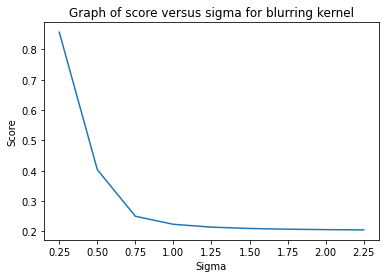

In [40]:
plt.xlabel('Sigma')
plt.title('Graph of score versus sigma for blurring kernel')
plt.ylabel('Score')
plt.plot(plot_sigma, plot_score)
plt.savefig('sigma-ablation.png')

### Check the time

In [61]:
def sort_indices_by_values(values):
    return sorted(range(len(values)), key=lambda i: np.abs(values[i]), reverse = True)

# Example usage:


In [ ]:
# Compute Centroid Distance

D00 = 0
D01 = 0
D10 = 0
D11 = 0
instance_scores = []
kernel = [0.3, 0.4, 0.3] 
N = 1
# distij is i label vector distance from centroid of class j
# We use L1 distance

start = time.time()

c0 = 0 * vectors[0]
c1 = 0 * vectors[0]
count0 = 0
count1 = 0

for i in tqdm.tqdm(range(len(vectors))):
    item = dataset_to_consider[i]
    if item['subtask_a'] == 'NOT':
        c0 += vectors[i]
        count0 += 1
    else:
        c1 += vectors[i]
        count1 += 1
        
clus0 = c0 / count0
clus1 = c1 / count1

for i in tqdm.tqdm(range(len(vectors))):
    item = dataset_to_consider[i]
    smoothened_vector = output_cnn(N, vectors[i], kernel)
    smoothened_cluster0 = output_cnn(N, clus0, kernel)
    smoothened_cluster1 = output_cnn(N, clus1, kernel)
    if item['subtask_a'] == 'NOT':
        dist00 = np.sum((smoothened_vector - smoothened_cluster0) ** 2)
        dist01 = np.sum((smoothened_vector - smoothened_cluster1) ** 2)
        D00 += dist00
        D01 += dist01
        score = np.abs(dist01 - dist00)
    else:
        dist10 = np.sum((smoothened_vector - smoothened_cluster0) ** 2)
        dist11 = np.sum((smoothened_vector - smoothened_cluster1) ** 2)
        D10 += dist10
        D11 += dist11
        score =  np.abs(dist11 - dist10)
    
    instance_scores.append(score)

duration = time.time() - start
print(duration)

print(D00/count0)
print(D01/count0)
print(D10/count1)
print(D11/count1)

In [16]:
c0 = 0
c1 = 0
j = 0
for i in instance_scores:
    item = dataset_to_consider[j]
    j += 1
    if np.abs(i) > 0.01:
        if item['subtask_a'] == 'NOT':
            c0 += 1
        else:
            c1 += 1
print(c0)
print(c1)
print(c0 + c1)

29
8
37


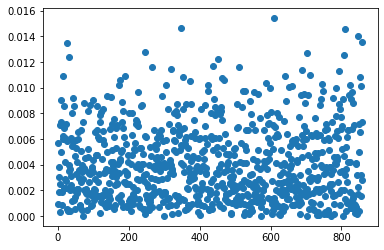

In [22]:
import matplotlib.pyplot as plt
import numpy as np

x = range(len(instance_scores))
y = instance_scores
plt.scatter(x, y)
plt.show()

In [78]:
# Compute Centroid Distance

D00 = 0
D01 = 0
D10 = 0
D11 = 0
instance_scores = []
kernel = [0.3, 0.4, 0.3] 
N = 2
# distij is i label vector distance from centroid of class j
# We use L1 distance

for i in tqdm.tqdm(range(len(vectors))):
    item = dataset_to_consider[i]
    smoothened_vector = output_cnn(N, vectors[i], kernel)
    smoothened_cluster0 = output_cnn(N, clus0, kernel)
    smoothened_cluster1 = output_cnn(N, clus1, kernel)
    if item['subtask_a'] == 'NOT':
        dist00 = np.sum((smoothened_vector - smoothened_cluster0) ** 2)
        dist01 = np.sum((smoothened_vector - smoothened_cluster1) ** 2)
        D00 += dist00
        D01 += dist01
        score = dist01
    else:
        dist10 = np.sum((smoothened_vector - smoothened_cluster0) ** 2)
        dist11 = np.sum((smoothened_vector - smoothened_cluster1) ** 2)
        D10 += dist10
        D11 += dist11
        score =  dist10
    
    instance_scores.append(score)
    

print(D00/count0)
print(D01/count0)
print(D10/count1)
print(D11/count1)

100%|██████████| 860/860 [00:10<00:00, 79.52it/s]

0.21249816323820342
0.21372560166798826
0.21242538588256818
0.21119794719933366


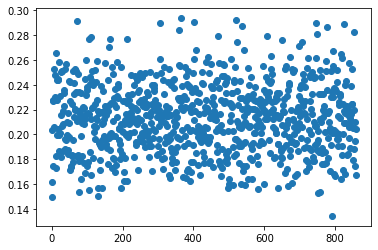

In [79]:
import matplotlib.pyplot as plt
import numpy as np

x = range(len(instance_scores))
y = instance_scores
plt.scatter(x, y)
plt.show()

In [40]:
with open('scores/OLID-MPNET/instance-scores-concat-OLID-L1-30-40-30.pkl', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(instance_scores, file)

### Check if clusters converge

In [22]:
def see_cluster_convergence(N):
    smoothened_cluster0 = output_cnn(N, clus0, kernel)
    smoothened_cluster1 = output_cnn(N, clus1, kernel)
    dist = np.sum(np.abs(smoothened_cluster0 - smoothened_cluster1))
    return dist

In [28]:
X = []
Y = []
for i in tqdm.tqdm(range(1, 300, 2)):
    X.append(i)
    Y.append(see_cluster_convergence(i + 1))

100%|██████████| 150/150 [01:32<00:00,  1.63it/s]


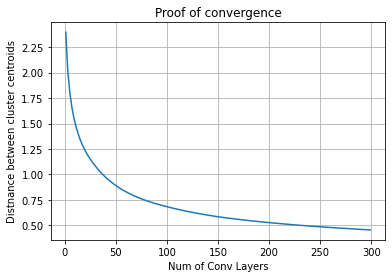

In [29]:
import matplotlib.pyplot as plt

# Plot the data
plt.plot(X, Y)
plt.title('Proof of convergence')
plt.xlabel('Num of Conv Layers')
plt.ylabel('Distnance between cluster centroids')
plt.grid(True)

# Save the plot as an image
plt.savefig('plot.png')

# Show the plot (optional)
plt.show()

[-0.7075557952126754,
 -0.5101028925089892,
 0.4599446244120209,
 -0.45171438769015815,
 -0.3721375027821727,
 -0.6374779923698348,
 0.4796113845517773,
 0.4614954161868816,
 -0.5605840228090546,
 0.4818929294659764,
 -0.47755780745626986,
 -0.4657966528742099,
 -0.5060331924903974,
 -0.45110464271878126,
 -0.5801653879877744,
 0.5251340264007123,
 -0.4976585207396047,
 0.6271930742605001,
 -0.6711661032273053,
 0.7067093367144821,
 0.4466513250758508,
 0.7837822995768597,
 0.6063903951776979,
 0.28377963829472996,
 -0.5110783148961584,
 0.5577058107546842,
 -0.5110376693886582,
 0.4576702952921208,
 0.7689337872353299,
 -0.5633390209585087,
 -0.5824353850023529,
 0.6859822795397648,
 -0.42716814855128327,
 -0.4413027203964406,
 -0.44410925637264675,
 0.6021619186645442,
 0.4708298041209016,
 0.5751328399112552,
 -0.41298540223361613,
 0.5302520111538573,
 -0.8440657314829654,
 -0.605910117732229,
 -0.7826722362519405,
 0.6602013177047432,
 -0.8258476246082544,
 0.658320468927803,
 0.6